# Testing Module

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt

from QLearn import *
from QLearn.q_agents import HeuristicAgent, QAgent
from QLearn.environment import Environment
from QLearn.run_agent import do_run

In [4]:
def heuristic(s):
    # Heuristic for:
    # 1. Testing. 
    # 2. Demonstration rollout.
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center (s[0] is horizontal coordinate, s[2] hor speed)
    if angle_targ >  0.4: angle_targ =  0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proporional to horizontal offset

    # PID controller: s[4] angle, s[5] angularSpeed
    angle_todo = (angle_targ - s[4])*0.5 - (s[5])*1.0
    #print("angle_targ=%0.2f, angle_todo=%0.2f" % (angle_targ, angle_todo))

    # PID controller: s[1] vertical coordinate s[3] vertical speed
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5
    #print("hover_targ=%0.2f, hover_todo=%0.2f" % (hover_targ, hover_todo))

    if s[6] or s[7]: # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    a = 0
    if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
    elif angle_todo < -0.05: a = 3
    elif angle_todo > +0.05: a = 1
    return a

In [33]:
env = Environment("gym_MarsLander:MarsLander-v0")
agent = HeuristicAgent(env,heuristic,net_type='MLPQNet',N_hid=[100, 50],N_heur=50,memory_size=100000,minibatch_size=30,alpha=0.005,clip_norm=1.0,eps0=0.8)
R, _, _ = do_run(agent, env, 600)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [35]:
R_dem = agent_demo(agent,env,5)

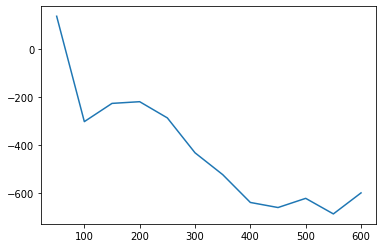

In [34]:
x,R = R.smooth(n_avg=50)
plt.plot(x,R)
plt.show()

In [36]:
env.gym_env.close()

In [37]:
R_dem

[-189.5371777798013,
 -189.46413695994335,
 -531.0769124459092,
 -430.48139835833007,
 -362.93171201198976]